In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cvxopt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV,train_test_split 
cvxopt.solvers.options['show_progress'] = False

In [2]:
def kernel_linear(**kwargs):
    def f(a, b):
        return np.inner(a, b)
    return f


def kernel_poly(degree, coef, **kwargs):
    def f(a, b):
        return (np.inner(a, b) + coef)**degree
    return f


def rbf_kernel(gamma, **kwargs):
    def f(a, b):
        distance = np.linalg.norm(a - b) ** 2
        return np.exp(-gamma * distance)
    return f

def kernel_sigmoid(**kwargs):
    def f(a,b):
        return (np.tanh(np.inner(a,b)))
    return f

In [3]:
class SVC(object):
    
    def __init__(self, C=1, kernel = rbf_kernel, degree=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None
    
    def fit(self, X,y):
        
        n_samples, n_features = np.shape(X)
        
        # par défaut gamma est 1/n_features
        if not self.gamma:
            self.gamma = 1 / n_features

        # initialisation du noyau
        self.kernel = self.kernel(
            degree=self.degree,
            gamma=self.gamma,
            coef=self.coef)

        
        kernel_matrix = np.zeros((n_samples,n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i,j] = self.kernel(X[i],X[j])
                
        P = cvxopt.matrix(np.outer(y, y) *kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples),tc='d')
        b = cvxopt.matrix(0, tc='d')
        
        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
            
        # Résolution du problème d'optimisation quadratique à l'aide de cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Lagrange multiplieurs
        lagr_mult = np.ravel(minimization['x'])
        
        # Extraction support vecteurs
        # Obtention des indexes non nulle du lagrange. multipieurs
        idx = lagr_mult > 1e-7
        # Obtention des correspondances non nulle du lagrange multiplieurs
        self.lagr_multipliers = lagr_mult[idx]
        # Obtention des échantillons qui serviront de vecteurs de support
        self.support_vectors = X[idx]
        # Obtention de leurs labels correspondants
        self.support_vector_labels = y[idx]
        
        
        # Calcul de l'interception avec le premier vecteur de support
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Parcourons X et faisons des prédictions
        for sample in X:
            prediction = 0
            # Déterminons l'étiquette de X
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)               

#### Importation données

In [4]:
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
#X = X / 255.
#y = y.astype('int64')
from sklearn.datasets import load_digits
mnist = load_digits()
X = mnist['data']
y = mnist['target']

#### Visualisation d'une image

In [5]:
def visualise_chiffre(X,y,i):
    plt.imshow(X[i].reshape(8, 8), cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.title('label:' + str(y[i]))
    plt.axis("on")
    plt.show()

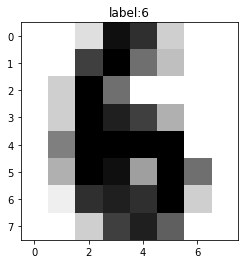

In [6]:
visualise_chiffre(X,y,452)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state = 42)

In [12]:
clf = SVC(kernel=kernel_poly, degree=4, coef=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [20]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
def classifieur_binaire(X_train,X_test,y_train,y_test,i):

    if (int(i) >= 0) & (int(i) <=9):
        y_train_binaire = (y_train == int(i))
        y_test_binaire = (y_test == int(i))

        param_grid = {'C': [0.1, 1],  
              'gamma': [1, 0.1], 
              'kernel': ['kernel_linear','kernel_poly']}  
  
        grid = GridSearchCV(SVC(), param_grid, cv = 5, verbose = 3) 
   
        grid.fit(X_train, y_train)

        grid_predictions = grid.predict(X_test)

        print(100*'-')
        print(grid.best_params_)

        print(100*'-')
        print(classification_report(y_test, grid_predictions)) 

    else: print("Désolé les labels sont entre 0 et 9")

In [16]:
classifieur_binaire(X_train,X_test,y_train,y_test,2)
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  

NameError: name 'classifieur_binaire' is not defined